In [ ]:
#import packages
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, datasets
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score

# Mount Google Drive for GPU use

In [ ]:
#mount google drive for GPU use
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Load Data

I Used the loadmat() function to store the matlab data and then transposed the training data to be compatible with the pytorch dataloaders. I also set the sizes for the training and validation datasets

In [ ]:
#set data paths
train_path = '/content/gdrive/My Drive/ComputerVision/train_32x32.mat'
test_path = '/content/gdrive/My Drive/ComputerVision/test_32x32.mat'

#load matlab data
train_data = loadmat(train_path)
test_data = loadmat(test_path)

#transpose data for dataloaders
train_data['X'] = np.transpose(train_data['X'], (3, 0, 1, 2))
test_data['X'] = np.transpose(test_data['X'], (3, 0, 1, 2))

In [ ]:
#initialize parameters for validation dataset
train_len = train_data['X'].shape[0]
train_ratio = 0.8
train_size = int(train_ratio * train_len)
val_size = train_len- train_size

# Initialize train and test dataloader

I instantiated a class for the dataset to easily apply transformations and dataloading. I also randomly divided the full training dataset into a training and validation set based off the parameters defined above.

In [ ]:
#initialize dataset class for data transformations
class SVHNDataset(Dataset):
    def __init__(self, data, transform=None):
        self.images = data['X']
        self.labels = data['y']
        self.transform = transform

    #function to get length
    def __len__(self):
        return len(self.images)

    #function to get items
    def __getitem__(self, idx):
        image, label = self.images[idx], int(self.labels[idx, 0] % 10)
        if self.transform:
            image = self.transform(image)
        return image, label


#define data transformations
transform = transforms.Compose([
    transforms.ToTensor()      #transform to tensor
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  #normalize data
])

#create train, val, and test datasets
full_train_dataset = SVHNDataset(train_data, transform=transform)
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])
test_dataset = SVHNDataset(test_data, transform=transform)

#set batch size
batch_size = 64
#set data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Create training function

Training function follows the general logic for model training used in previous homeworks. For each epoch I added a validation cycle that tests the model with the validation dataset. I decided to use 20 epochs for training. At the end of training the function outputs a plot for training and validttion loss and accuracy through the epochs.

In [ ]:
#training function
def train_model(model, optimizer, criterion, num_epochs=20):
  #device parameters for GPU use
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  #move model to GPU
  model = model.to(device)

  #lists to store training and validation metrics
  train_loss_history = []
  val_loss_history = []
  train_acc_history = []
  val_acc_history = []

  #training loop
  for epoch in range(num_epochs):
      model.train()
      total_train_loss = 0.0
      correct_train = 0
      total_train = 0
      #loop through batches
      for inputs, labels in train_loader:
          #put data on GPU
          inputs, labels = inputs.to(device), labels.to(device)
          #reset gradient
          optimizer.zero_grad()
          outputs = model(inputs)
          loss = criterion(outputs, labels)
          #backpropagate
          loss.backward()
          optimizer.step()
          #update metrics
          total_train_loss += loss.item()
          _, predicted = torch.max(outputs, 1)
          total_train += labels.size(0)
          correct_train += (predicted == labels).sum().item()

      #calculate training accuracy and loss
      train_accuracy = correct_train / total_train
      train_loss = total_train_loss / len(train_loader)

      #validation loop
      model.eval()
      total_val_loss = 0.0
      correct_val = 0
      total_val = 0
      #disable gradient
      with torch.no_grad():
          #loop through batches
          for inputs, labels in val_loader:
              #put data on GPU
              inputs, labels = inputs.to(device), labels.to(device)
              outputs = model(inputs)
              loss = criterion(outputs, labels)
              #update metrics
              total_val_loss += loss.item()
              _, predicted = torch.max(outputs, 1)
              total_val += labels.size(0)
              correct_val += (predicted == labels).sum().item()

      #calculate validation accuracy and loss
      val_accuracy = correct_val / total_val
      val_loss = total_val_loss / len(val_loader)

      #print and store metrics
      print(f"Epoch {epoch + 1}/{num_epochs} => "
            f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, "
            f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

      #update metrics
      train_loss_history.append(train_loss)
      val_loss_history.append(val_loss)
      train_acc_history.append(train_accuracy)
      val_acc_history.append(val_accuracy)

  #plot loss and accuracy
  plot_metrics(train_loss_history, val_loss_history, train_acc_history, val_acc_history, num_epochs)

# Create testing function

The test_model function predicts labels for the test data and then calculates the accuracy over the entire testing dataset.

In [ ]:
#function for testing model
def test_model(model):
  #set device and metrics
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  correct = 0
  total = 0
  #loop through batches
  for inputs, labels in test_loader:
    #put data on GPU
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)
    _, predicted = torch.max(outputs, 1)
    #update metrics
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

  #print metrics
  print(f'Model Test Accuracy: {correct / total}')

# Create plotting function

The plot_metrics function using matplotlib to create plot that track the loss and accuracy while training

In [ ]:
def plot_metrics(train_loss, val_loss, train_acc, val_acc, num_epochs=10):
  epochs = list(range(1, num_epochs + 1))
  #plotting training and validation loss
  plt.figure(figsize=(12, 5))
  #plot loss metrics
  plt.subplot(1, 2, 1)
  plt.plot(epochs, train_loss, label='Training Loss')
  plt.plot(epochs, val_loss, label='Validation Loss')
  plt.title('Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  #plot accuracy metrics
  plt.subplot(1, 2, 2)
  plt.plot(epochs, train_acc, label='Training Accuracy')
  plt.plot(epochs, val_acc, label='Validation Accuracy')
  plt.title('Training and Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  #show plot
  plt.tight_layout()
  plt.show()


# First model

My first model has two convolutional layers each with the ReLu activation function and max pooling. The first layer takes in the 3 RGB channels and outputs 32, the second layer takes the 32 channels and increases it 64. I then have a fully connected layer which flattens the output from the last convulational layer and outputs 512 connections. I then apply a dropout with 0.5 probability to reduce overfitting and finish the CNN with a fully connected layer that takes the 512 inputs and brings it down to the number of classes which is 10. I then define the forward function for the model in which I apply a full layer in each line of code. <br>

I chose to go with this structure for my first model since I wanted to start with a simple base that I could experiment and add on to in future iterations. To make it a more effective starting model I decided to add max pooling and dropout.

In [ ]:
class CNN1(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN1, self).__init__()

        #first convolutional layer with ReLu and max pooling
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        #second convulational layer with ReLu and max pooling
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        #fully connected layers and dropout
        self.fc1 = nn.Linear(64 * 8 * 8, 512)
        self.relu3 = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        #apply convolutional layers
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        #reshape for fc layers
        x = x.view(-1, 64 * 8 * 8)
        x = self.dropout(self.relu3(self.fc1(x)))
        x = self.fc2(x)
        return x

#create an instance of the CNN
model1 = CNN1()

#print the architecture of the CNN
print(model1)

CNN1(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=512, bias=True)
  (relu3): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)


I used Cross Entropy for my loss function and chose the Adam optimizer with a standard learning rate of 0.001 for training.

Epoch 1/20 => Train Loss: 1.2245, Train Acc: 0.5950, Val Loss: 0.5903, Val Acc: 0.8294
Epoch 2/20 => Train Loss: 0.6017, Train Acc: 0.8192, Val Loss: 0.4747, Val Acc: 0.8595
Epoch 3/20 => Train Loss: 0.5119, Train Acc: 0.8478, Val Loss: 0.4221, Val Acc: 0.8743
Epoch 4/20 => Train Loss: 0.4628, Train Acc: 0.8599, Val Loss: 0.4136, Val Acc: 0.8787
Epoch 5/20 => Train Loss: 0.4337, Train Acc: 0.8676, Val Loss: 0.3885, Val Acc: 0.8872
Epoch 6/20 => Train Loss: 0.4028, Train Acc: 0.8780, Val Loss: 0.3840, Val Acc: 0.8873
Epoch 7/20 => Train Loss: 0.3791, Train Acc: 0.8839, Val Loss: 0.3780, Val Acc: 0.8870
Epoch 8/20 => Train Loss: 0.3591, Train Acc: 0.8912, Val Loss: 0.3667, Val Acc: 0.8946
Epoch 9/20 => Train Loss: 0.3415, Train Acc: 0.8959, Val Loss: 0.3637, Val Acc: 0.8954
Epoch 10/20 => Train Loss: 0.3223, Train Acc: 0.9005, Val Loss: 0.3552, Val Acc: 0.8982
Epoch 11/20 => Train Loss: 0.3088, Train Acc: 0.9046, Val Loss: 0.3622, Val Acc: 0.8977
Epoch 12/20 => Train Loss: 0.2980, Train 

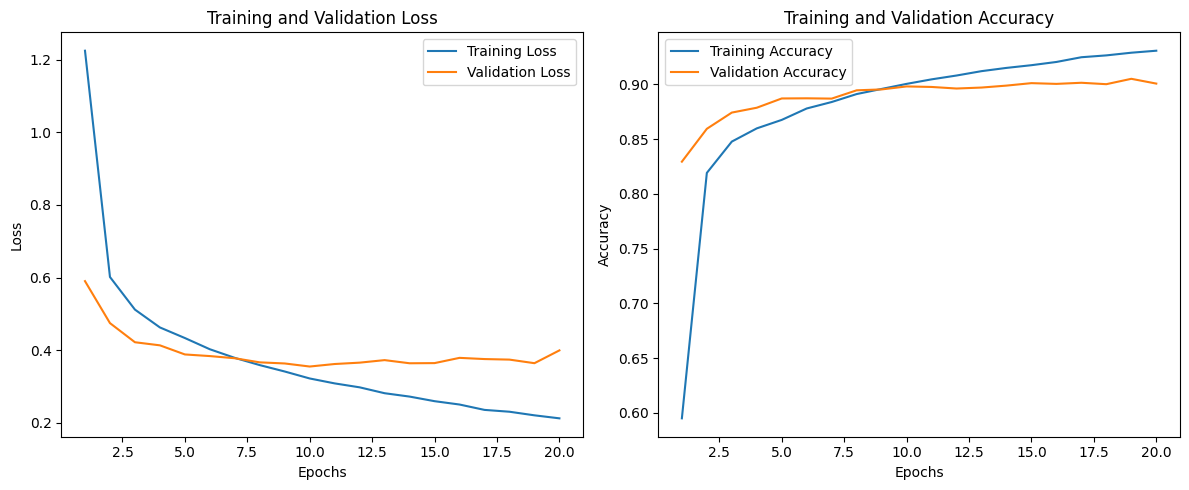

In [ ]:
#set loss function and optimizer
criterion1 = nn.CrossEntropyLoss()
optimizer1 = optim.Adam(model1.parameters(), lr=0.001)
#train model
train_model(model1, optimizer1, criterion1)

In [ ]:
#evaluate model on test dataset
test_model(model1)

Model Test Accuracy: 0.8913644744929318


# Second model

My second model is much more complex than my starting model. Some key improvements are the addition of 4 more convolutional layers, the application of batch normalization, and more uses of dropout. Each convolutional block consists of two convolutional layers followed by a ReLU activation.
Batch normalization is applied after the first ReLU in each block.
Max pooling and dropout are applied after the second ReLU in each block.
Fully Connected Layers (Block 4):

The flattened output from the last convolutional block is passed through two fully connected layers.
ReLU activation and dropout are applied to the output of the first fully connected layer.

Batch normalization is introduced in convolutional blocks to stabilize and accelerate training.
Dropout is applied after each max pooling layer, providing regularization during training.
The number of parameters and model complexity are increased compared to the previous model, potentially allowing for better representation learning.
In summary, the additional use of batch normalization and dropout in this model aims to improve its generalization capability and training stability. The effectiveness of these improvements may depend on the specific characteristics of your dataset and the nature of your classification task. Adjustments may be necessary based on empirical performance and experimentation.

I reached this final model by deciding to add more complexity upon the first model.

In [ ]:
class CNN2(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN2, self).__init__()

        #first convolutional layer with ReLu and batch normalization
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.batchnorm1 = nn.BatchNorm2d(32)
        #second convolutional layer with ReLu, max pooling and dropout
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(0.3)
        #third convolutional layer with ReLu and batch normalization
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        self.batchnorm2 = nn.BatchNorm2d(64)
        #fourth convolutional layer with ReLu, max pooling, and dropout
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.relu4 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout(0.3)
        #fifth convolutional layer with ReLu and batch normalization
        self.conv5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.relu5 = nn.ReLU()
        self.batchnorm3 = nn.BatchNorm2d(128)
        #sixth convolutional layer with ReLu, max pooling, and dropout
        self.conv6 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.relu6 = nn.ReLU()
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout3 = nn.Dropout(0.3)
        #flatten for fc layers
        self.flatten = nn.Flatten()
        #first fc layer with ReLu
        self.fc1 = nn.Linear(128 * 4 * 4, 128)
        self.relu7 = nn.ReLU()
        #dropout in between fc layer
        self.dropout4 = nn.Dropout(0.4)
        #second and final fc layer
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        #apply convolutional layers
        x = self.dropout1(self.maxpool1(self.relu2(self.conv2(self.batchnorm1(self.relu1(self.conv1(x)))))))
        x = self.dropout2(self.maxpool2(self.relu4(self.conv4(self.batchnorm2(self.relu3(self.conv3(x)))))))
        x = self.dropout3(self.maxpool3(self.relu6(self.conv6(self.batchnorm3(self.relu5(self.conv5(x)))))))
        #flatten for fc layers
        x = self.flatten(x)
        #apply fc layers
        x = self.dropout4(self.relu7(self.fc1(x)))
        x = self.fc2(x)
        return x

#create an instance of the CNN
model2 = CNN2()

#print the architecture of the CNN
print(model2)

CNN2(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (batchnorm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.3, inplace=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (batchnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu4): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.3, inplace=False)
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu5): ReLU()
  (batchnorm3): BatchNorm2d(128, eps=1e-05, momentum=0.1, aff

Epoch 1/20 => Train Loss: 1.3344, Train Acc: 0.5281, Val Loss: 0.5349, Val Acc: 0.8478
Epoch 2/20 => Train Loss: 0.6573, Train Acc: 0.7969, Val Loss: 0.3689, Val Acc: 0.8920
Epoch 3/20 => Train Loss: 0.4431, Train Acc: 0.8749, Val Loss: 0.3028, Val Acc: 0.9128
Epoch 4/20 => Train Loss: 0.3592, Train Acc: 0.8994, Val Loss: 0.2706, Val Acc: 0.9226
Epoch 5/20 => Train Loss: 0.3191, Train Acc: 0.9108, Val Loss: 0.2814, Val Acc: 0.9206
Epoch 6/20 => Train Loss: 0.2921, Train Acc: 0.9181, Val Loss: 0.2855, Val Acc: 0.9178
Epoch 7/20 => Train Loss: 0.2778, Train Acc: 0.9212, Val Loss: 0.2441, Val Acc: 0.9347
Epoch 8/20 => Train Loss: 0.2551, Train Acc: 0.9287, Val Loss: 0.2355, Val Acc: 0.9356
Epoch 9/20 => Train Loss: 0.2450, Train Acc: 0.9303, Val Loss: 0.2379, Val Acc: 0.9366
Epoch 10/20 => Train Loss: 0.2343, Train Acc: 0.9332, Val Loss: 0.2405, Val Acc: 0.9368
Epoch 11/20 => Train Loss: 0.2241, Train Acc: 0.9359, Val Loss: 0.2416, Val Acc: 0.9336
Epoch 12/20 => Train Loss: 0.2125, Train 

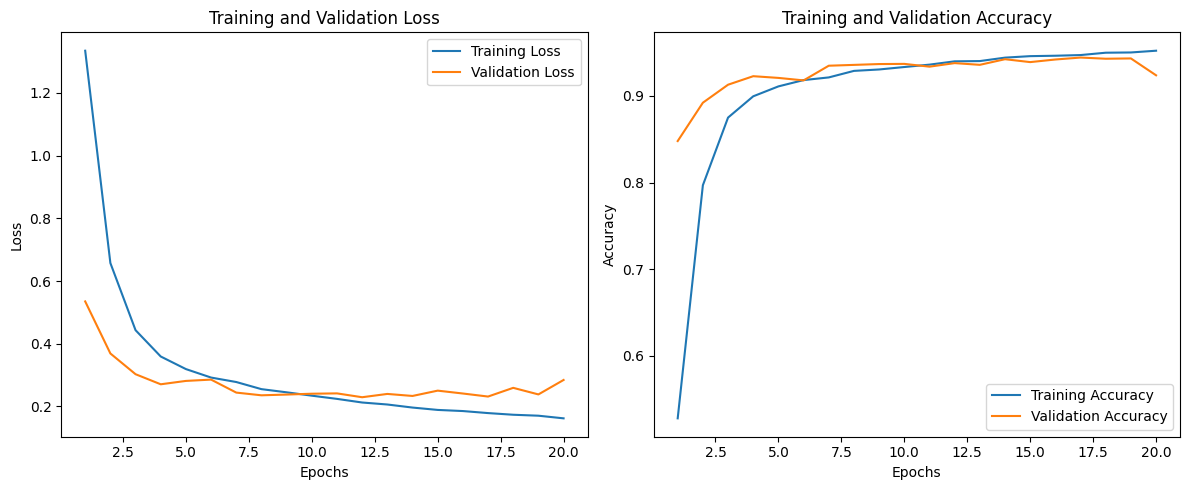

In [ ]:
#set loss function and optimizer
criterion2 = nn.CrossEntropyLoss()
optimizer2 = optim.Adam(model2.parameters(), lr=0.001)
#train model
train_model(model2, optimizer2, criterion2)

In [ ]:
#evaluate model on test dataset
test_model(model2)

Model Test Accuracy: 0.9343116164720344


# Difficulties and Improvement

I had some initial difficulties with loading the data and getting the dataloaders to work properly. I also had a little difficulty splitting the training dataset into a training and validation set. I opted to use the dataset class to make that process work. Everything else in terms of model creation and training went smoothly

I think further improvements on this model could be made by further parameter turning. I didn't experiment too much with the learning rates or other parameters of the optimizer so a good next step could be do to a grid search on the models parameters to try and improve accuracy. It's possible that more preprocessing work on the images could also improve accuracy.